In [15]:
import pandas as pd
import pypsa
import matplotlib.pyplot as plt

### Creating a one bus for the Netherlands

In [3]:
network = pypsa.Network()
hours_in_2023 = pd.date_range('2017-01-01 00:00Z',
                              '2017-12-31 23:00Z',
                              freq='h')

network.set_snapshots(hours_in_2023.values)

network.add("Bus",
            "electricity bus")

network.snapshots

DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 01:00:00',
               '2017-01-01 02:00:00', '2017-01-01 03:00:00',
               '2017-01-01 04:00:00', '2017-01-01 05:00:00',
               '2017-01-01 06:00:00', '2017-01-01 07:00:00',
               '2017-01-01 08:00:00', '2017-01-01 09:00:00',
               ...
               '2017-12-31 14:00:00', '2017-12-31 15:00:00',
               '2017-12-31 16:00:00', '2017-12-31 17:00:00',
               '2017-12-31 18:00:00', '2017-12-31 19:00:00',
               '2017-12-31 20:00:00', '2017-12-31 21:00:00',
               '2017-12-31 22:00:00', '2017-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

#### Getting the demand for the Netherlands and adding it to the bus

In [5]:
# Define file path
file_path = "Data\demand_data.csv"

# Load dataset
data = pd.read_csv(file_path, sep=';', parse_dates=['utc_timestamp'], index_col='utc_timestamp')

# Rename columns (if necessary)
data.columns = [
    'cet_cest_timestamp', 'NL_load_actual_entsoe_transparency',
    'NL_load_forecast_entsoe_transparency', 'NL_solar_generation_actual',
    'NL_wind_generation_actual', 'NL_wind_offshore_generation_actual',
    'NL_wind_onshore_generation_actual'
]

# Convert index to datetime format
data.index = pd.to_datetime(data.index, utc=True)

start_date = '2017-01-01 00:00:00+00:00'
end_date = '2017-12-31 23:00:00+00:00'

data = data[start_date:end_date]
print(data.head())
country = 'NLD'

<>:2: DeprecationWarning: invalid escape sequence '\d'
<>:2: DeprecationWarning: invalid escape sequence '\d'
C:\Users\Julia\AppData\Local\Temp\ipykernel_30536\2064595465.py:2: DeprecationWarning: invalid escape sequence '\d'
  file_path = "Data\demand_data.csv"


                                 cet_cest_timestamp  \
utc_timestamp                                         
2017-01-01 00:00:00+00:00  2017-01-01T01:00:00+0100   
2017-01-01 01:00:00+00:00  2017-01-01T02:00:00+0100   
2017-01-01 02:00:00+00:00  2017-01-01T03:00:00+0100   
2017-01-01 03:00:00+00:00  2017-01-01T04:00:00+0100   
2017-01-01 04:00:00+00:00  2017-01-01T05:00:00+0100   

                           NL_load_actual_entsoe_transparency  \
utc_timestamp                                                   
2017-01-01 00:00:00+00:00                             10794.0   
2017-01-01 01:00:00+00:00                             10320.0   
2017-01-01 02:00:00+00:00                              9930.0   
2017-01-01 03:00:00+00:00                              9679.0   
2017-01-01 04:00:00+00:00                              9652.0   

                           NL_load_forecast_entsoe_transparency  \
utc_timestamp                                                     
2017-01-01 00:00:00+00:0

In [6]:
# add load to the bus
network.add("Load",
            "load",
            bus="electricity bus",
            p_set=data['NL_load_actual_entsoe_transparency'].values)

Index(['load'], dtype='object')

In [7]:
network.loads_t.p_set

Load,load
snapshot,
2017-01-01 00:00:00,10794.0
2017-01-01 01:00:00,10320.0
2017-01-01 02:00:00,9930.0
2017-01-01 03:00:00,9679.0
2017-01-01 04:00:00,9652.0
...,...
2017-12-31 19:00:00,12703.0
2017-12-31 20:00:00,11961.0
2017-12-31 21:00:00,11478.0


#### Adding different generation types 

In [8]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n
    
print(annuity(25,0.07))
print(annuity(25,0.07)*425000*(1+0.03))

0.0858105172206656
37563.55391334636


In [9]:
# add the different carriers, only gas emits CO2
network.add("Carrier", "gas", co2_emissions=0.19) # in /MWh_tt_CO2h
network.add("Carrier", "coal", co2_emissions=0.3) # in /MWh_tt_CO2h
network.add("Carrier", "offshorewind")
network.add("Carrier", "onshorewind")
network.add("Carrier", "solar")

# add onshore wind generator
df_onshorewind = pd.read_csv('Data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
CF_wind = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_onshorewind = annuity(30,0.07)*910000*(1+0.033) # in €/MW
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind.values)

# add offshore wind generator
df_offshorewind = pd.read_csv('Data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshorewind.index = pd.to_datetime(df_offshorewind.index)
CF_wind = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_offshorewind = annuity(30,0.07)*1000000*(1+0.033) # in €/MW
network.add("Generator",
            "offshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_offshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind.values)

# add solar PV generator
df_solar = pd.read_csv('Data/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)
CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_solar = annuity(25,0.07)*425000*(1+0.03) # in €/MW
network.add("Generator",
            "solar",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_solar,
            marginal_cost = 0,
            p_max_pu = CF_solar.values)

# add OCGT (Open Cycle Gas Turbine) generator
capital_cost_OCGT = annuity(25,0.07)*560000*(1+0.033) # in €/MW
fuel_cost = 21.6 # in €/MWh_th
efficiency = 0.39 # MWh_elec/MWh_th
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT)


# add coal power plant  generator
capital_cost_coal = annuity(30,0.07)*700000*(1+0.033) # in €/MW
fuel_cost = 30 # in €/MWh_th
efficiency = 0.42 # MWh_elec/MWh_th
marginal_cost_coal = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "coal",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="coal",
            #p_nom_max=1000,
            capital_cost = capital_cost_coal,
            marginal_cost = marginal_cost_coal)

Index(['coal'], dtype='object')

In [10]:
network.generators_t.p_max_pu

Generator,offshorewind,onshorewind,solar
snapshot,,,
2017-01-01 00:00:00,0.691,0.350,0.0
2017-01-01 01:00:00,0.732,0.377,0.0
2017-01-01 02:00:00,0.743,0.385,0.0
2017-01-01 03:00:00,0.748,0.400,0.0
2017-01-01 04:00:00,0.734,0.406,0.0
...,...,...,...
2017-12-31 19:00:00,0.711,0.468,0.0
2017-12-31 20:00:00,0.809,0.595,0.0
2017-12-31 21:00:00,0.877,0.684,0.0


In [12]:
network.optimize(solver_name='gurobi')

Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]
INFO:linopy.io: Writing time: 1.32s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-j719bak8.lp


INFO:gurobipy:Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-j719bak8.lp


Reading time = 0.38 seconds


INFO:gurobipy:Reading time = 0.38 seconds


obj: 96365 rows, 43805 columns, 170819 nonzeros


INFO:gurobipy:obj: 96365 rows, 43805 columns, 170819 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 3500U with Radeon Vega Mobile Gfx, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 3500U with Radeon Vega Mobile Gfx, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 96365 rows, 43805 columns and 170819 nonzeros


INFO:gurobipy:Optimize a model with 96365 rows, 43805 columns and 170819 nonzeros


Model fingerprint: 0x7f4c6bf0


INFO:gurobipy:Model fingerprint: 0x7f4c6bf0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [6e+01, 8e+04]


INFO:gurobipy:  Objective range  [6e+01, 8e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [9e+03, 2e+04]


INFO:gurobipy:  RHS range        [9e+03, 2e+04]


Presolve removed 48191 rows and 4386 columns


INFO:gurobipy:Presolve removed 48191 rows and 4386 columns


Presolve time: 0.26s


INFO:gurobipy:Presolve time: 0.26s


Presolved: 48174 rows, 39419 columns, 118242 nonzeros


INFO:gurobipy:Presolved: 48174 rows, 39419 columns, 118242 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 5


INFO:gurobipy: Dense cols : 5


 AA' NZ     : 7.883e+04


INFO:gurobipy: AA' NZ     : 7.883e+04


 Factor NZ  : 3.766e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 3.766e+05 (roughly 40 MB of memory)


 Factor Ops : 3.091e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.091e+06 (less than 1 second per iteration)


 Threads    : 3


INFO:gurobipy: Threads    : 3


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.23642269e+10  0.00000000e+00  1.12e+05 0.00e+00  2.41e+07     1s


INFO:gurobipy:   0   5.23642269e+10  0.00000000e+00  1.12e+05 0.00e+00  2.41e+07     1s


   1   5.53683787e+10 -8.33665850e+10  1.48e+04 2.29e+02  5.49e+06     1s


INFO:gurobipy:   1   5.53683787e+10 -8.33665850e+10  1.48e+04 2.29e+02  5.49e+06     1s


   2   3.98489551e+10 -2.39605130e+10  2.18e-11 3.79e+00  5.88e+05     1s


INFO:gurobipy:   2   3.98489551e+10 -2.39605130e+10  2.18e-11 3.79e+00  5.88e+05     1s


   3   1.89529856e+10 -7.32493451e+08  4.37e-11 1.61e-01  1.72e+05     1s


INFO:gurobipy:   3   1.89529856e+10 -7.32493451e+08  4.37e-11 1.61e-01  1.72e+05     1s


   4   1.30637437e+10  1.03392948e+09  2.91e-11 2.65e-01  1.04e+05     1s


INFO:gurobipy:   4   1.30637437e+10  1.03392948e+09  2.91e-11 2.65e-01  1.04e+05     1s


   5   1.03705261e+10  2.16566279e+09  3.64e-11 1.72e-01  7.08e+04     1s


INFO:gurobipy:   5   1.03705261e+10  2.16566279e+09  3.64e-11 1.72e-01  7.08e+04     1s


   6   8.75164578e+09  3.17738878e+09  8.00e-11 2.10e-01  4.80e+04     1s


INFO:gurobipy:   6   8.75164578e+09  3.17738878e+09  8.00e-11 2.10e-01  4.80e+04     1s


   7   7.95715781e+09  4.50113760e+09  3.09e-10 6.83e-02  2.95e+04     1s


INFO:gurobipy:   7   7.95715781e+09  4.50113760e+09  3.09e-10 6.83e-02  2.95e+04     1s


   8   7.72931258e+09  4.86253730e+09  7.76e-09 4.41e-02  2.44e+04     1s


INFO:gurobipy:   8   7.72931258e+09  4.86253730e+09  7.76e-09 4.41e-02  2.44e+04     1s


   9   7.56872467e+09  4.99026636e+09  9.42e-08 3.73e-02  2.20e+04     1s


INFO:gurobipy:   9   7.56872467e+09  4.99026636e+09  9.42e-08 3.73e-02  2.20e+04     1s


  10   6.89290475e+09  5.28746436e+09  1.35e-08 1.42e-02  1.37e+04     1s


INFO:gurobipy:  10   6.89290475e+09  5.28746436e+09  1.35e-08 1.42e-02  1.37e+04     1s


  11   6.38567671e+09  5.49153734e+09  1.41e-07 6.75e-03  7.62e+03     1s


INFO:gurobipy:  11   6.38567671e+09  5.49153734e+09  1.41e-07 6.75e-03  7.62e+03     1s


  12   6.16615001e+09  5.57445706e+09  1.11e-07 4.42e-03  5.05e+03     1s


INFO:gurobipy:  12   6.16615001e+09  5.57445706e+09  1.11e-07 4.42e-03  5.05e+03     1s


  13   6.07261525e+09  5.66028729e+09  2.45e-07 2.94e-03  3.52e+03     1s


INFO:gurobipy:  13   6.07261525e+09  5.66028729e+09  2.45e-07 2.94e-03  3.52e+03     1s


  14   6.00887858e+09  5.73095151e+09  1.07e-06 1.70e-03  2.37e+03     1s


INFO:gurobipy:  14   6.00887858e+09  5.73095151e+09  1.07e-06 1.70e-03  2.37e+03     1s


  15   5.95672720e+09  5.75811839e+09  1.68e-06 1.22e-03  1.69e+03     1s


INFO:gurobipy:  15   5.95672720e+09  5.75811839e+09  1.68e-06 1.22e-03  1.69e+03     1s


  16   5.92093907e+09  5.79693811e+09  2.71e-06 5.10e-04  1.05e+03     1s


INFO:gurobipy:  16   5.92093907e+09  5.79693811e+09  2.71e-06 5.10e-04  1.05e+03     1s


  17   5.89020865e+09  5.81322774e+09  1.78e-06 1.80e-04  6.53e+02     2s


INFO:gurobipy:  17   5.89020865e+09  5.81322774e+09  1.78e-06 1.80e-04  6.53e+02     2s


  18   5.86932403e+09  5.81566431e+09  5.89e-07 6.91e-05  4.55e+02     2s


INFO:gurobipy:  18   5.86932403e+09  5.81566431e+09  5.89e-07 6.91e-05  4.55e+02     2s


  19   5.84962539e+09  5.81697043e+09  2.67e-06 0.00e+00  2.78e+02     2s


INFO:gurobipy:  19   5.84962539e+09  5.81697043e+09  2.67e-06 0.00e+00  2.78e+02     2s


  20   5.84765615e+09  5.81825847e+09  2.70e-06 2.20e-10  2.50e+02     2s


INFO:gurobipy:  20   5.84765615e+09  5.81825847e+09  2.70e-06 2.20e-10  2.50e+02     2s


  21   5.84690322e+09  5.82018709e+09  2.79e-06 2.79e-10  2.27e+02     2s


INFO:gurobipy:  21   5.84690322e+09  5.82018709e+09  2.79e-06 2.79e-10  2.27e+02     2s


  22   5.83372163e+09  5.82147649e+09  2.03e-06 1.42e-10  1.04e+02     2s


INFO:gurobipy:  22   5.83372163e+09  5.82147649e+09  2.03e-06 1.42e-10  1.04e+02     2s


  23   5.83032178e+09  5.82306903e+09  9.07e-07 1.01e-09  6.15e+01     2s


INFO:gurobipy:  23   5.83032178e+09  5.82306903e+09  9.07e-07 1.01e-09  6.15e+01     2s


  24   5.82592462e+09  5.82311082e+09  3.13e-05 1.06e-09  2.39e+01     2s


INFO:gurobipy:  24   5.82592462e+09  5.82311082e+09  3.13e-05 1.06e-09  2.39e+01     2s


  25   5.82434020e+09  5.82352993e+09  7.66e-06 1.97e-09  6.89e+00     2s


INFO:gurobipy:  25   5.82434020e+09  5.82352993e+09  7.66e-06 1.97e-09  6.89e+00     2s


  26   5.82391315e+09  5.82370312e+09  1.67e-06 2.83e-09  1.79e+00     2s


INFO:gurobipy:  26   5.82391315e+09  5.82370312e+09  1.67e-06 2.83e-09  1.79e+00     2s


  27   5.82378872e+09  5.82378184e+09  3.61e-07 2.19e-08  5.84e-02     2s


INFO:gurobipy:  27   5.82378872e+09  5.82378184e+09  3.61e-07 2.19e-08  5.84e-02     2s


  28   5.82378460e+09  5.82378459e+09  4.78e-08 1.20e-09  5.94e-05     2s


INFO:gurobipy:  28   5.82378460e+09  5.82378459e+09  4.78e-08 1.20e-09  5.94e-05     2s


  29   5.82378460e+09  5.82378460e+09  1.63e-10 1.20e-09  5.94e-08     2s


INFO:gurobipy:  29   5.82378460e+09  5.82378460e+09  1.63e-10 1.20e-09  5.94e-08     2s


  30   5.82378460e+09  5.82378460e+09  3.09e-11 1.11e-09  5.94e-14     2s


INFO:gurobipy:  30   5.82378460e+09  5.82378460e+09  3.09e-11 1.11e-09  5.94e-14     2s


INFO:gurobipy:


Barrier solved model in 30 iterations and 2.45 seconds (0.53 work units)


INFO:gurobipy:Barrier solved model in 30 iterations and 2.45 seconds (0.53 work units)


Optimal objective 5.82378460e+09


INFO:gurobipy:Optimal objective 5.82378460e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   17552 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:   17552 DPushes remaining with DInf 0.0000000e+00                 3s


       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:


    1000 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:    1000 PPushes remaining with PInf 0.0000000e+00                 3s


       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.4478721e-09      3s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.4478721e-09      3s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    7810    5.8237846e+09   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:    7810    5.8237846e+09   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 7810 iterations and 3.04 seconds (0.60 work units)


INFO:gurobipy:Solved in 7810 iterations and 3.04 seconds (0.60 work units)


Optimal objective  5.823784597e+09


INFO:gurobipy:Optimal objective  5.823784597e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43805 primals, 96365 duals
Objective: 5.82e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [13]:
print(network.objective/1000000) #in 10^6 €

5823.784596568709


In [14]:
print(network.objective/network.loads_t.p.sum()) # EUR/MWh

Load
load    51.159856
dtype: float64


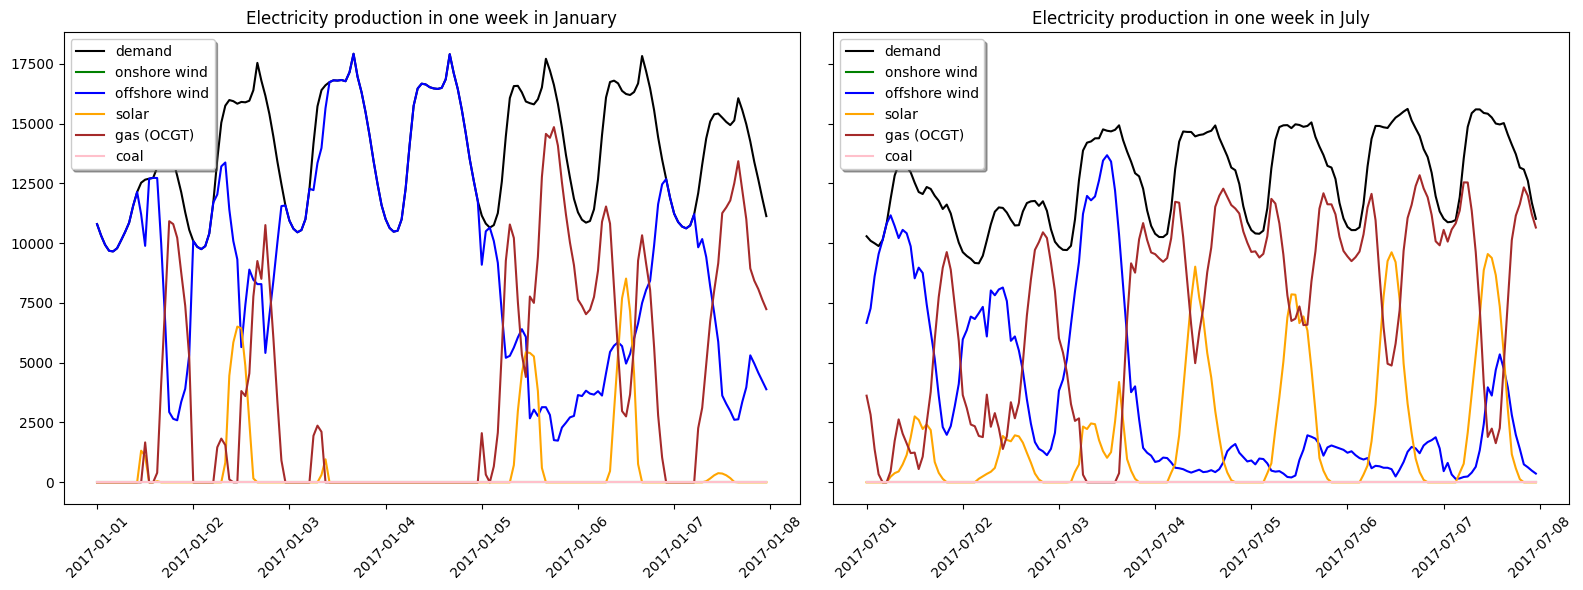

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 columns

# --- Winter Week (January) ---
axes[0].plot(network.loads_t.p['load'][0:168], color='black', label='demand')
axes[0].plot(network.generators_t.p['onshorewind'][0:168], color='green', label='onshore wind')
axes[0].plot(network.generators_t.p['offshorewind'][0:168], color='blue', label='offshore wind')
axes[0].plot(network.generators_t.p['solar'][0:168], color='orange', label='solar')
axes[0].plot(network.generators_t.p['OCGT'][0:168], color='brown', label='gas (OCGT)')
axes[0].plot(network.generators_t.p['coal'][0:168], color='pink', label='coal')
axes[0].legend(fancybox=True, shadow=True, loc='best')
axes[0].set_title('Electricity production in one week in January')
axes[0].tick_params(axis='x', rotation=45)

# --- Summer Week (July) ---
axes[1].plot(network.loads_t.p['load'][4344:4512], color='black', label='demand')
axes[1].plot(network.generators_t.p['onshorewind'][4344:4512], color='green', label='onshore wind')
axes[1].plot(network.generators_t.p['offshorewind'][4344:4512], color='blue', label='offshore wind')
axes[1].plot(network.generators_t.p['solar'][4344:4512], color='orange', label='solar')
axes[1].plot(network.generators_t.p['OCGT'][4344:4512], color='brown', label='gas (OCGT)')
axes[1].plot(network.generators_t.p['coal'][4344:4512], color='pink', label='coal')
axes[1].legend(fancybox=True, shadow=True, loc='best')
axes[1].set_title('Electricity production in one week in July')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Electricity mix

Text(0.5, 1.07, 'Electricity mix')

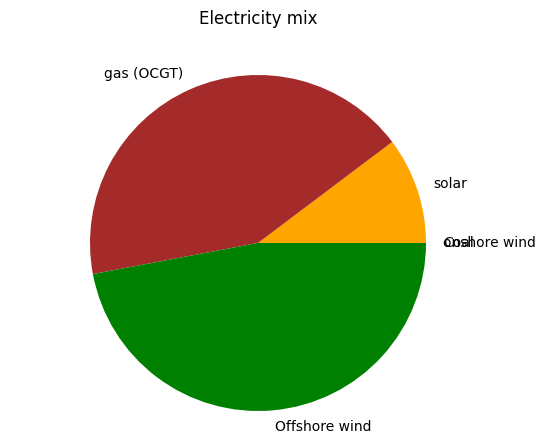

In [24]:
labels = ['onshore wind',
          'solar',
          'gas (OCGT)',
          'Offshore wind',
          'Coal']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['OCGT'].sum(),
         network.generators_t.p['offshorewind'].sum(),
        network.generators_t.p['coal'].sum()]

colors=['blue', 'orange', 'brown', 'green', 'black']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

## CO2 limit 

Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]
INFO:linopy.io: Writing time: 2.08s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-9jk7pumg.lp


INFO:gurobipy:Read LP format model from file C:\Users\Julia\AppData\Local\Temp\linopy-problem-9jk7pumg.lp


Reading time = 0.55 seconds


INFO:gurobipy:Reading time = 0.55 seconds


obj: 96366 rows, 43805 columns, 188339 nonzeros


INFO:gurobipy:obj: 96366 rows, 43805 columns, 188339 nonzeros


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 3500U with Radeon Vega Mobile Gfx, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 3500U with Radeon Vega Mobile Gfx, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 96366 rows, 43805 columns and 188339 nonzeros


INFO:gurobipy:Optimize a model with 96366 rows, 43805 columns and 188339 nonzeros


Model fingerprint: 0xdc6b9202


INFO:gurobipy:Model fingerprint: 0xdc6b9202


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [6e+01, 8e+04]


INFO:gurobipy:  Objective range  [6e+01, 8e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [9e+03, 6e+07]


INFO:gurobipy:  RHS range        [9e+03, 6e+07]


Presolve removed 48192 rows and 4386 columns


INFO:gurobipy:Presolve removed 48192 rows and 4386 columns


Presolve time: 0.33s


INFO:gurobipy:Presolve time: 0.33s


Presolved: 48174 rows, 39419 columns, 118242 nonzeros


INFO:gurobipy:Presolved: 48174 rows, 39419 columns, 118242 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.05s


INFO:gurobipy:Ordering time: 0.05s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 5


INFO:gurobipy: Dense cols : 5


 AA' NZ     : 7.883e+04


INFO:gurobipy: AA' NZ     : 7.883e+04


 Factor NZ  : 3.766e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 3.766e+05 (roughly 40 MB of memory)


 Factor Ops : 3.091e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 3.091e+06 (less than 1 second per iteration)


 Threads    : 3


INFO:gurobipy: Threads    : 3


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.23642269e+10  0.00000000e+00  1.12e+05 0.00e+00  2.41e+07     1s


INFO:gurobipy:   0   5.23642269e+10  0.00000000e+00  1.12e+05 0.00e+00  2.41e+07     1s


   1   5.53683787e+10 -8.33665850e+10  1.48e+04 2.29e+02  5.49e+06     1s


INFO:gurobipy:   1   5.53683787e+10 -8.33665850e+10  1.48e+04 2.29e+02  5.49e+06     1s


   2   3.98489551e+10 -2.39605130e+10  2.18e-11 3.79e+00  5.88e+05     1s


INFO:gurobipy:   2   3.98489551e+10 -2.39605130e+10  2.18e-11 3.79e+00  5.88e+05     1s


   3   1.89529856e+10 -7.32493451e+08  4.37e-11 1.61e-01  1.72e+05     1s


INFO:gurobipy:   3   1.89529856e+10 -7.32493451e+08  4.37e-11 1.61e-01  1.72e+05     1s


   4   1.30637437e+10  1.03392948e+09  2.91e-11 2.65e-01  1.04e+05     1s


INFO:gurobipy:   4   1.30637437e+10  1.03392948e+09  2.91e-11 2.65e-01  1.04e+05     1s


   5   1.03705261e+10  2.16566279e+09  3.64e-11 1.72e-01  7.08e+04     1s


INFO:gurobipy:   5   1.03705261e+10  2.16566279e+09  3.64e-11 1.72e-01  7.08e+04     1s


   6   8.75164578e+09  3.17738878e+09  8.00e-11 2.10e-01  4.80e+04     1s


INFO:gurobipy:   6   8.75164578e+09  3.17738878e+09  8.00e-11 2.10e-01  4.80e+04     1s


   7   7.95715781e+09  4.50113760e+09  3.09e-10 6.83e-02  2.95e+04     1s


INFO:gurobipy:   7   7.95715781e+09  4.50113760e+09  3.09e-10 6.83e-02  2.95e+04     1s


   8   7.72931258e+09  4.86253730e+09  7.76e-09 4.41e-02  2.44e+04     1s


INFO:gurobipy:   8   7.72931258e+09  4.86253730e+09  7.76e-09 4.41e-02  2.44e+04     1s


   9   7.56872467e+09  4.99026636e+09  9.42e-08 3.73e-02  2.20e+04     2s


INFO:gurobipy:   9   7.56872467e+09  4.99026636e+09  9.42e-08 3.73e-02  2.20e+04     2s


  10   6.89290475e+09  5.28746436e+09  1.35e-08 1.42e-02  1.37e+04     2s


INFO:gurobipy:  10   6.89290475e+09  5.28746436e+09  1.35e-08 1.42e-02  1.37e+04     2s


  11   6.38567671e+09  5.49153734e+09  1.41e-07 6.75e-03  7.62e+03     2s


INFO:gurobipy:  11   6.38567671e+09  5.49153734e+09  1.41e-07 6.75e-03  7.62e+03     2s


  12   6.16615001e+09  5.57445706e+09  1.11e-07 4.42e-03  5.05e+03     2s


INFO:gurobipy:  12   6.16615001e+09  5.57445706e+09  1.11e-07 4.42e-03  5.05e+03     2s


  13   6.07261525e+09  5.66028729e+09  2.45e-07 2.94e-03  3.52e+03     2s


INFO:gurobipy:  13   6.07261525e+09  5.66028729e+09  2.45e-07 2.94e-03  3.52e+03     2s


  14   6.00887858e+09  5.73095151e+09  1.07e-06 1.70e-03  2.37e+03     2s


INFO:gurobipy:  14   6.00887858e+09  5.73095151e+09  1.07e-06 1.70e-03  2.37e+03     2s


  15   5.95672720e+09  5.75811839e+09  1.68e-06 1.22e-03  1.69e+03     2s


INFO:gurobipy:  15   5.95672720e+09  5.75811839e+09  1.68e-06 1.22e-03  1.69e+03     2s


  16   5.92093907e+09  5.79693811e+09  2.71e-06 5.10e-04  1.05e+03     2s


INFO:gurobipy:  16   5.92093907e+09  5.79693811e+09  2.71e-06 5.10e-04  1.05e+03     2s


  17   5.89020865e+09  5.81322774e+09  1.78e-06 1.80e-04  6.53e+02     2s


INFO:gurobipy:  17   5.89020865e+09  5.81322774e+09  1.78e-06 1.80e-04  6.53e+02     2s


  18   5.86932403e+09  5.81566431e+09  5.89e-07 6.91e-05  4.55e+02     2s


INFO:gurobipy:  18   5.86932403e+09  5.81566431e+09  5.89e-07 6.91e-05  4.55e+02     2s


  19   5.84962539e+09  5.81697043e+09  2.67e-06 0.00e+00  2.78e+02     2s


INFO:gurobipy:  19   5.84962539e+09  5.81697043e+09  2.67e-06 0.00e+00  2.78e+02     2s


  20   5.84765615e+09  5.81825847e+09  2.70e-06 2.20e-10  2.50e+02     2s


INFO:gurobipy:  20   5.84765615e+09  5.81825847e+09  2.70e-06 2.20e-10  2.50e+02     2s


  21   5.84690322e+09  5.82018709e+09  2.79e-06 2.79e-10  2.27e+02     2s


INFO:gurobipy:  21   5.84690322e+09  5.82018709e+09  2.79e-06 2.79e-10  2.27e+02     2s


  22   5.83372163e+09  5.82147649e+09  2.03e-06 1.42e-10  1.04e+02     2s


INFO:gurobipy:  22   5.83372163e+09  5.82147649e+09  2.03e-06 1.42e-10  1.04e+02     2s


  23   5.83032178e+09  5.82306903e+09  9.07e-07 1.01e-09  6.15e+01     2s


INFO:gurobipy:  23   5.83032178e+09  5.82306903e+09  9.07e-07 1.01e-09  6.15e+01     2s


  24   5.82592462e+09  5.82311082e+09  3.13e-05 1.06e-09  2.39e+01     3s


INFO:gurobipy:  24   5.82592462e+09  5.82311082e+09  3.13e-05 1.06e-09  2.39e+01     3s


  25   5.82434020e+09  5.82352993e+09  7.66e-06 1.97e-09  6.89e+00     3s


INFO:gurobipy:  25   5.82434020e+09  5.82352993e+09  7.66e-06 1.97e-09  6.89e+00     3s


  26   5.82391315e+09  5.82370312e+09  1.67e-06 2.83e-09  1.79e+00     3s


INFO:gurobipy:  26   5.82391315e+09  5.82370312e+09  1.67e-06 2.83e-09  1.79e+00     3s


  27   5.82378872e+09  5.82378184e+09  3.61e-07 2.19e-08  5.84e-02     3s


INFO:gurobipy:  27   5.82378872e+09  5.82378184e+09  3.61e-07 2.19e-08  5.84e-02     3s


  28   5.82378460e+09  5.82378459e+09  4.78e-08 1.20e-09  5.94e-05     3s


INFO:gurobipy:  28   5.82378460e+09  5.82378459e+09  4.78e-08 1.20e-09  5.94e-05     3s


  29   5.82378460e+09  5.82378460e+09  1.63e-10 1.20e-09  5.94e-08     3s


INFO:gurobipy:  29   5.82378460e+09  5.82378460e+09  1.63e-10 1.20e-09  5.94e-08     3s


  30   5.82378460e+09  5.82378460e+09  3.09e-11 1.11e-09  5.94e-14     3s


INFO:gurobipy:  30   5.82378460e+09  5.82378460e+09  3.09e-11 1.11e-09  5.94e-14     3s


INFO:gurobipy:


Barrier solved model in 30 iterations and 2.99 seconds (0.56 work units)


INFO:gurobipy:Barrier solved model in 30 iterations and 2.99 seconds (0.56 work units)


Optimal objective 5.82378460e+09


INFO:gurobipy:Optimal objective 5.82378460e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   17552 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:   17552 DPushes remaining with DInf 0.0000000e+00                 3s


       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:


    1000 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:    1000 PPushes remaining with PInf 0.0000000e+00                 3s


       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.4478721e-09      3s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.4478721e-09      3s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    7810    5.8237846e+09   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:    7810    5.8237846e+09   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:


Solved in 7810 iterations and 3.51 seconds (0.63 work units)


INFO:gurobipy:Solved in 7810 iterations and 3.51 seconds (0.63 work units)


Optimal objective  5.823784597e+09


INFO:gurobipy:Optimal objective  5.823784597e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43805 primals, 96366 duals
Objective: 5.82e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Text(0.5, 1.07, 'Electricity mix')

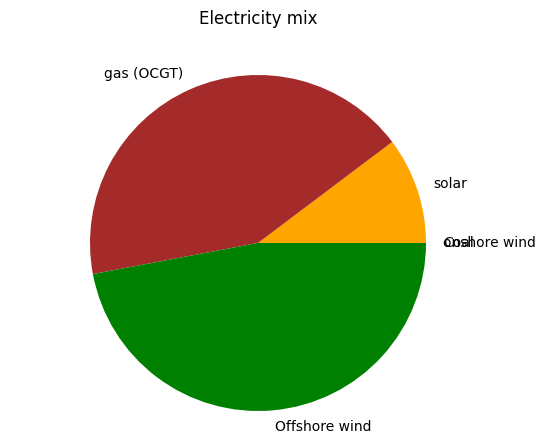

In [27]:
co2_limit=38564880#tonCO2
network.add("GlobalConstraint",
            "co2_limit",
            type="primary_energy",
            carrier_attribute="co2_emissions",
            sense="<=",
            constant=co2_limit)
network.optimize(solver_name='gurobi')
labels = ['onshore wind',
          'solar',
          'gas (OCGT)',
          'Offshore wind',
          'Coal']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['OCGT'].sum(),
         network.generators_t.p['offshorewind'].sum(),
        network.generators_t.p['coal'].sum()]

colors=['blue', 'orange', 'brown', 'green', 'black']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

In [26]:
print(network.objective/1000000) #in 10^6 €

5823.784596568709
